## Final Lesson - Applied Econometrics with Python

The final class is dedicated to Applied Econometrics, specifically using Python. How do we run a linear regression in Python? How can we obtain the results?

Before we can run a linear regression, we need to conduct data cleaning, processing and manipulation. This draws on the previous lessons we have learnt. If there are any missing variables in the dataset, we have to impute the missing data, or remove the variable, since running a regression requires the observations to be present.

#### Case-Study approach

Similar to the previous lessons, we will be adopting a case-study approach to learn more about the different regressions that can be done in Python. Specifically, we will be using the Titanic dataset. In addition, we will be using the following techniques taught in the previous lessons:

1. Data Manipulation, Processing and Cleaning 
2. Imputing Missing Data
3. Feature Generation

The first and second section relies on much that we have learnt in lesson 3 on data manipulation, while the last section relies much on the 4th lesson. Without further ado, let's apply our understanding on the Titanic dataset.

### Preliminary Data Exploration

In this section, we import key libraries and read the training and test data into Python. We look at summary statistics to get a better understanding of what we are currently dealing with.

In [54]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def read_and_combine_data(train_filepath, test_filepath):
    # This function combines the training and test dataset into 1 dataset
    train = pd.read_csv(train_filepath, index_col=0)
    test = pd.read_csv(test_filepath, index_col=0)
    
    combine = pd.concat([train, test], sort=True)
    return combine

train_filepath = 'data/titanic/train.csv'
test_filepath = 'data/titanic/test.csv'
train = pd.read_csv(train_filepath, index_col=0)
test = pd.read_csv(test_filepath, index_col=0)


combine = read_and_combine_data(train_filepath, test_filepath)

In [55]:
combine.head()

Age Cabin Embarked     Fare  \
PassengerId                                 
1            22.0   NaN        S   7.2500   
2            38.0   C85        C  71.2833   
3            26.0   NaN        S   7.9250   
4            35.0  C123        S  53.1000   
5            35.0   NaN        S   8.0500   

                                                          Name  Parch  Pclass  \
PassengerId                                                                     
1                                      Braund, Mr. Owen Harris      0       3   
2            Cumings, Mrs. John Bradley (Florence Briggs Th...      0       1   
3                                       Heikkinen, Miss. Laina      0       3   
4                 Futrelle, Mrs. Jacques Heath (Lily May Peel)      0       1   
5                                     Allen, Mr. William Henry      0       3   

                Sex  SibSp  Survived            Ticket  
PassengerId                                             
1              male      1       0.0         A/5 21171  
2            female      1       1.0          PC 17599  
3            female      0       1.0  STON/O2. 3101282  
4            female      1       1.0            113803  
5              male      0       0.0            373450

In [56]:
combine.describe(include='all')

Age        Cabin Embarked         Fare                  Name  \
count   1046.000000          295     1307  1308.000000                  1309   
unique          NaN          186        3          NaN                  1307   
top             NaN  C23 C25 C27        S          NaN  Connolly, Miss. Kate   
freq            NaN            6      914          NaN                     2   
mean      29.881138          NaN      NaN    33.295479                   NaN   
std       14.413493          NaN      NaN    51.758668                   NaN   
min        0.170000          NaN      NaN     0.000000                   NaN   
25%       21.000000          NaN      NaN     7.895800                   NaN   
50%       28.000000          NaN      NaN    14.454200                   NaN   
75%       39.000000          NaN      NaN    31.275000                   NaN   
max       80.000000          NaN      NaN   512.329200                   NaN   

              Parch       Pclass   Sex        SibSp    Survived    Ticket  
count   1309.000000  1309.000000  1309  1309.000000  891.000000      1309  
unique          NaN          NaN     2          NaN         NaN       929  
top             NaN          NaN  male          NaN         NaN  CA. 2343  
freq            NaN          NaN   843          NaN         NaN        11  
mean       0.385027     2.294882   NaN     0.498854    0.383838       NaN  
std        0.865560     0.837836   NaN     1.041658    0.486592       NaN  
min        0.000000     1.000000   NaN     0.000000    0.000000       NaN  
25%        0.000000     2.000000   NaN     0.000000    0.000000       NaN  
50%        0.000000     3.000000   NaN     0.000000    0.000000       NaN  
75%        0.000000     3.000000   NaN     1.000000    1.000000       NaN  
max        9.000000     3.000000   NaN     8.000000    1.000000       NaN

### Imputing Missing Data

In our case, we are tasked to predict whether a passenger survived based on the features in the model. However, some of these features are not as useful as others, and we can generate new features using a combination of different features. Before we do that however, we check for missing data.

In [57]:
np.sum(pd.isnull(combine))

Age          263
Cabin       1014
Embarked       2
Fare           1
Name           0
Parch          0
Pclass         0
Sex            0
SibSp          0
Survived     418
Ticket         0
dtype: int64

We note that there are quite a significant number of observations with missing data. To circumvent this, we can create a new column for the "Cabin" variable, to indicate that the data are missing. For the "Embarked" and "Fare" feature, we can impute the most popular embarkation point and the average fare.

In [58]:
combine.Embarked.value_counts()

S    914
C    270
Q    123
Name: Embarked, dtype: int64

In [59]:
combine.Fare.mean()

33.2954792813456

In [60]:
def impute_missing_cabins():
    return combine.Cabin.fillna("N", inplace=True)

def impute_missing_embarkation_point():
    return combine.Embarked.fillna("S", inplace=True)

def impute_missing_fare():
    return combine.Fare.fillna(combine.Fare.mean(), inplace=True)

impute_missing_cabins()
impute_missing_embarkation_point()
impute_missing_fare()

In [61]:
np.sum(pd.isnull(combine))

Age         263
Cabin         0
Embarked      0
Fare          0
Name          0
Parch         0
Pclass        0
Sex           0
SibSp         0
Survived    418
Ticket        0
dtype: int64

We are left with the age variable. There are a few ways to resolve this issue:

1. Drop the age variable.
2. Impute the missing ages with the average age of the dataset
3. Use conditional information to determine the missing age

Of the 3, the third way is the hardest - we will do the third way. 

We first split the Name column into First and Last Name, bearing in mind that the designation of the passenger may contain some important information on the age of the passenger. Let's take a look at an example. The first element in the Name column is "Braund, Mr. Owen Harris". Splitting on space yields the following list: ["Braund,", "Mr.", "Owen", "Harris"].

What happens when we split on ", "?

In [62]:
combine.Name.iloc[0].split(", ")

['Braund', 'Mr. Owen Harris']

In [63]:
def get_desg_first_name(name):
    # This returns the second element after splitting on the pattern ", "
    return name.split(", ")[1]

def get_first_name():
    # Fist, we ob
    first_name = combine.Name.apply(lambda x: get_desg_first_name(x))
    combine['FirstName'] = first_name.apply(lambda x: x.split(". ")[1])
    combine['Designation'] = first_name.apply(lambda x: x.split(". ")[0])
    return combine
    
def get_last_name():
    combine['LastName'] = combine.Name.apply(lambda x: x.split(", ")[0])
    return combine

get_last_name()
get_first_name()
print('Done.')

Done.


In [64]:
combine.head()

Age Cabin Embarked     Fare  \
PassengerId                                 
1            22.0     N        S   7.2500   
2            38.0   C85        C  71.2833   
3            26.0     N        S   7.9250   
4            35.0  C123        S  53.1000   
5            35.0     N        S   8.0500   

                                                          Name  Parch  Pclass  \
PassengerId                                                                     
1                                      Braund, Mr. Owen Harris      0       3   
2            Cumings, Mrs. John Bradley (Florence Briggs Th...      0       1   
3                                       Heikkinen, Miss. Laina      0       3   
4                 Futrelle, Mrs. Jacques Heath (Lily May Peel)      0       1   
5                                     Allen, Mr. William Henry      0       3   

                Sex  SibSp  Survived            Ticket   LastName  \
PassengerId                                                         
1              male      1       0.0         A/5 21171     Braund   
2            female      1       1.0          PC 17599    Cumings   
3            female      0       1.0  STON/O2. 3101282  Heikkinen   
4            female      1       1.0            113803   Futrelle   
5              male      0       0.0            373450      Allen   

                                         FirstName Designation  
PassengerId                                                     
1                                      Owen Harris          Mr  
2            John Bradley (Florence Briggs Thayer)         Mrs  
3                                            Laina        Miss  
4                    Jacques Heath (Lily May Peel)         Mrs  
5                                    William Henry          Mr

Note that the column, "Designation" can be used to impute missing data for the "Age" variable. Suppose we have a missing data with the designation, "Miss". We can look at the mean value for all observations with the same designation and impute that as the missing value.

In [65]:
combine.groupby("Designation")['Age'].mean()

Designation
Capt            70.000000
Col             54.000000
Don             40.000000
Dona            39.000000
Dr              43.571429
Jonkheer        38.000000
Lady            48.000000
Major           48.500000
Master           5.482642
Miss            21.774238
Mlle            24.000000
Mme             24.000000
Mr              32.252151
Mrs             36.994118
Ms              28.000000
Rev             41.250000
Sir             49.000000
the Countess    33.000000
Name: Age, dtype: float64

In [66]:
def impute_missing_age():
    '''
    Generate a pd.Series using information on Designation to impute missing age data
    '''
    age_list = []
    for age, desg in zip(combine.Age, combine.Designation):
        if pd.isnull(age):
            age_list.append(combine.groupby("Designation")['Age'].mean()[desg])
        else: age_list.append(age)
    return age_list

combine['NewAge'] = impute_missing_age()

We check for missing data once again. If everything turns out to be fine, we can begin to explore the relationships inherent in the data.

In [67]:
np.sum(pd.isnull(combine))

Age            263
Cabin            0
Embarked         0
Fare             0
Name             0
Parch            0
Pclass           0
Sex              0
SibSp            0
Survived       418
Ticket           0
LastName         0
FirstName        0
Designation      0
NewAge           0
dtype: int64

It turns out that the new age column, "NewAge" has no more missing observations. 

### Data Exploration and Plotting
Everything seems good. We can proceed with data exploration using plots. We begin with some hypotheses that we are interested in, and see what that leads to. Here are some possible hypotheses one may be interested in testing:

1. Age is correlated with Survival Rate
2. Fare is correlated with Survival Rate
3. Designation is correlated with Survival Rate

From there, we can generate additional hypotheses: can an interaction term between Gender x Age lead to even better results? 

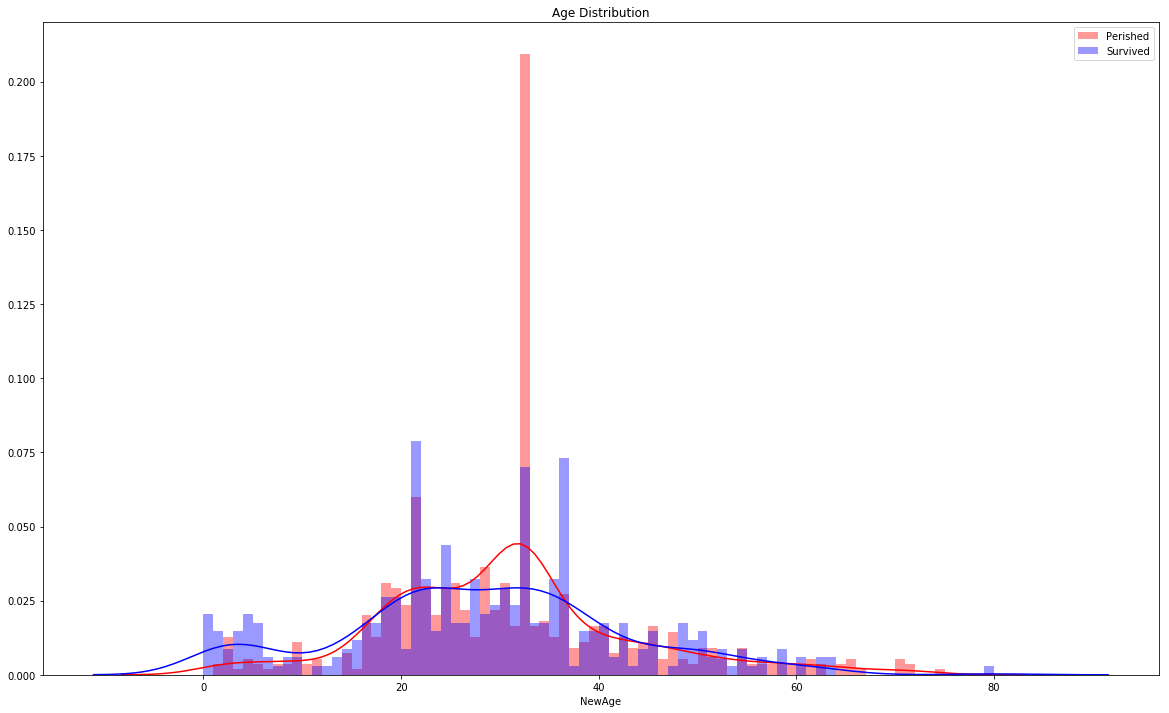

In [68]:
### Hypothesis 1 - Age is correlated with Survival Rate
plt.figure(figsize=(20, 12))
sns.distplot(combine[combine.Survived == 0].NewAge, bins=range(0, 81, 1), color = 'red', label='Perished')
sns.distplot(combine[combine.Survived == 1].NewAge, bins=range(0, 81, 1), color = 'blue', label='Survived')
plt.legend(loc='upper right')
plt.title("Age Distribution")
plt.show()

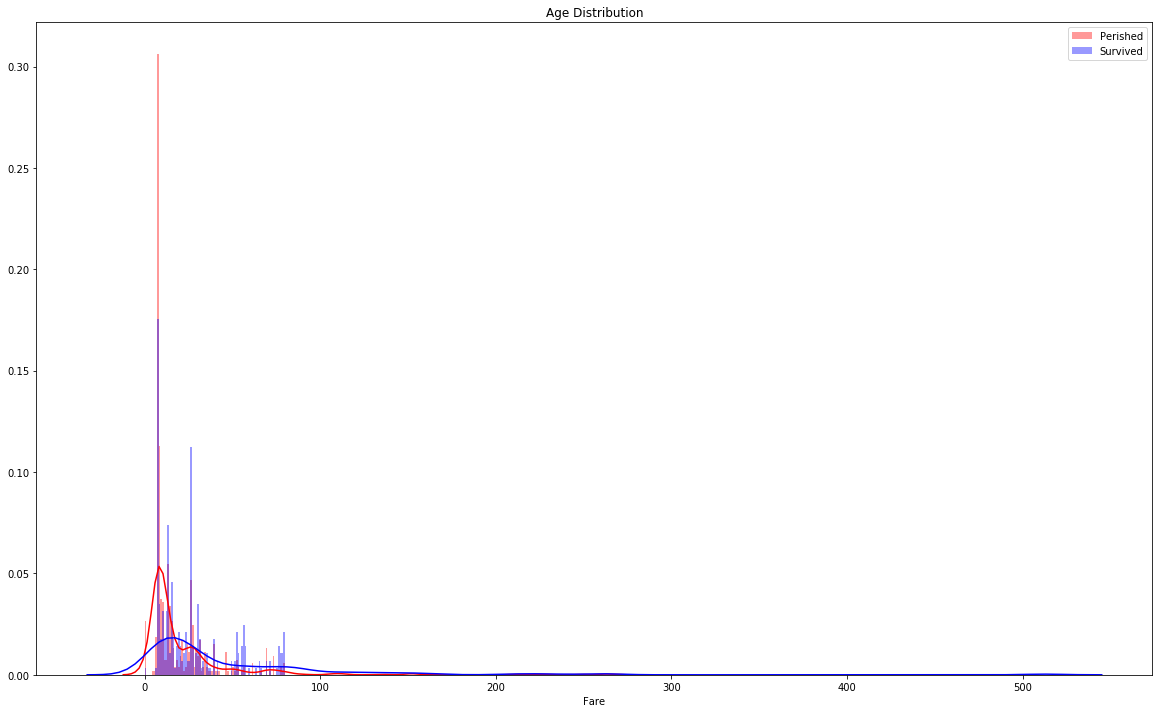

In [69]:
### Hypothesis 2 - Fare is correlated with Survival Rate
plt.figure(figsize=(20, 12))
sns.distplot(combine[combine.Survived == 0].Fare, bins=range(0, 81, 1), color = 'red', label='Perished')
sns.distplot(combine[combine.Survived == 1].Fare, bins=range(0, 81, 1), color = 'blue', label='Survived')
plt.legend(loc='upper right')
plt.title("Age Distribution")
plt.show()

From the graphs above, it appears that passengers who are young tend to survive the Titanic crash. In addition, passengers who paid more for their fare tended to have a higher rate of survival. However, something stands out. There appears to be anomaly in the dataset - some passengers paid way more than \$100 for their fare.

We **may** need to conduct a secondary analysis to ensure that this is indeed an anomaly.

---

Let's test the third hypothesis.

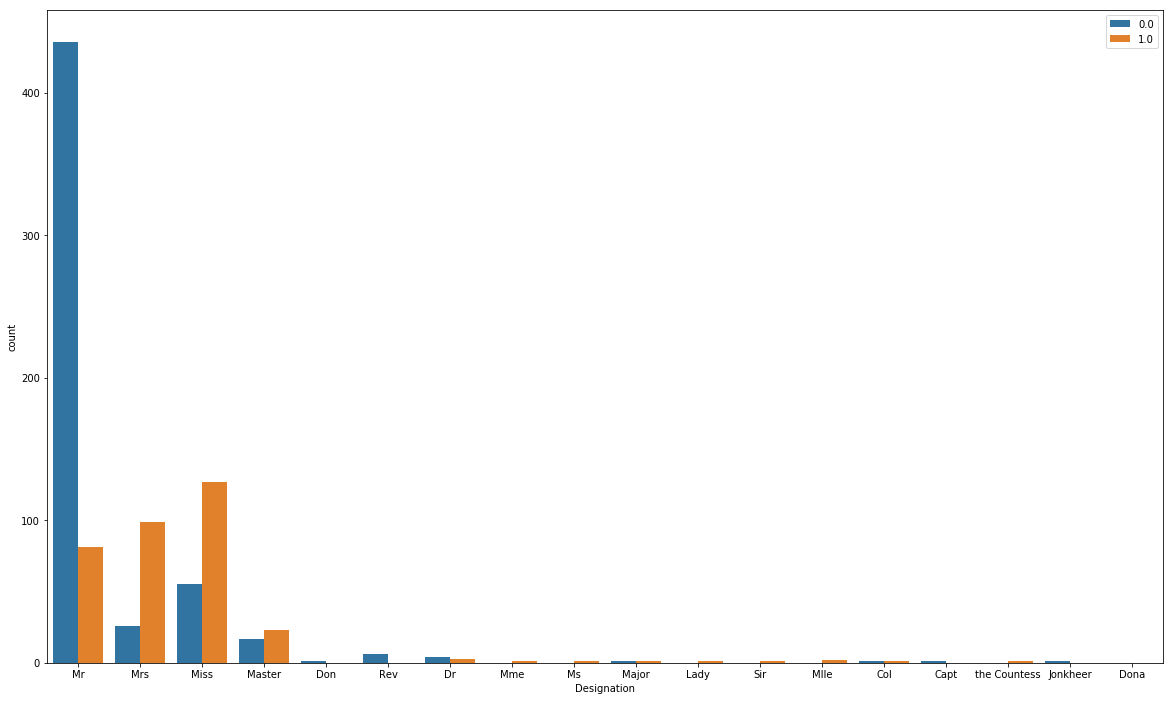

In [70]:
### Hypothesis 3 - Designation is correlated with Survival Rate
plt.figure(figsize=(20, 12))
sns.countplot("Designation", hue='Survived', data=combine)
plt.legend(loc='upper right')
plt.show()

The above plot seems to imply the following:

1. Male passengers have a relatively low survival rate, compared to females
2. Children tend to have a relatively high survival rate (their Designation is Master) 
3. There is not enough data about the other Designations to draw a decisive conclusion

---

Other hypotheses that we can carry out are as follows:

1. Could the feature Ticket be correlated with the Survival Variable?
2. Are passengers with Siblings/Spouses and Parents/Children more likely to survive than passengers travelling alone?

In [71]:
len(np.unique(combine.Ticket))

929

In [72]:
len(combine.Ticket)

1309

We note that there are 929 unique value for tickets, but there are 1309 entries. Some passengers might be sharing tickets! To determine how many people are sharing tickets, we can use the DataFrame method, `groupby`. This can be done using the following function:

In [73]:
combine.groupby('Ticket').size()

Ticket
110152               3
110413               3
110465               2
110469               1
110489               1
110564               1
110813               2
111163               1
111240               1
111320               1
111361               2
111369               1
111426               1
111427               1
111428               1
112050               1
112051               1
112052               1
112053               1
112058               2
112059               1
112277               1
112377               1
112378               2
112379               1
112901               1
113028               1
113038               1
113043               1
113044               1
                    ..
STON/O 2. 3101273    1
STON/O 2. 3101274    1
STON/O 2. 3101275    1
STON/O 2. 3101280    1
STON/O 2. 3101285    1
STON/O 2. 3101286    1
STON/O 2. 3101288    1
STON/O 2. 3101289    1
STON/O 2. 3101291    1
STON/O 2. 3101292    1
STON/O 2. 3101293    1
STON/O 2. 3101294    1
STON

We note that there are 3 people sharing the same ticket, "110152". The following function returns the number of passengers that are holding a ticket number similar to the passenger ID, including himself:

In [74]:
# We group by the ticket number, and count the number of times the same ticket number appears in the column
combine.groupby('Ticket')['Name'].transform("count").head()

PassengerId
1    1
2    2
3    1
4    2
5    1
Name: Name, dtype: int64

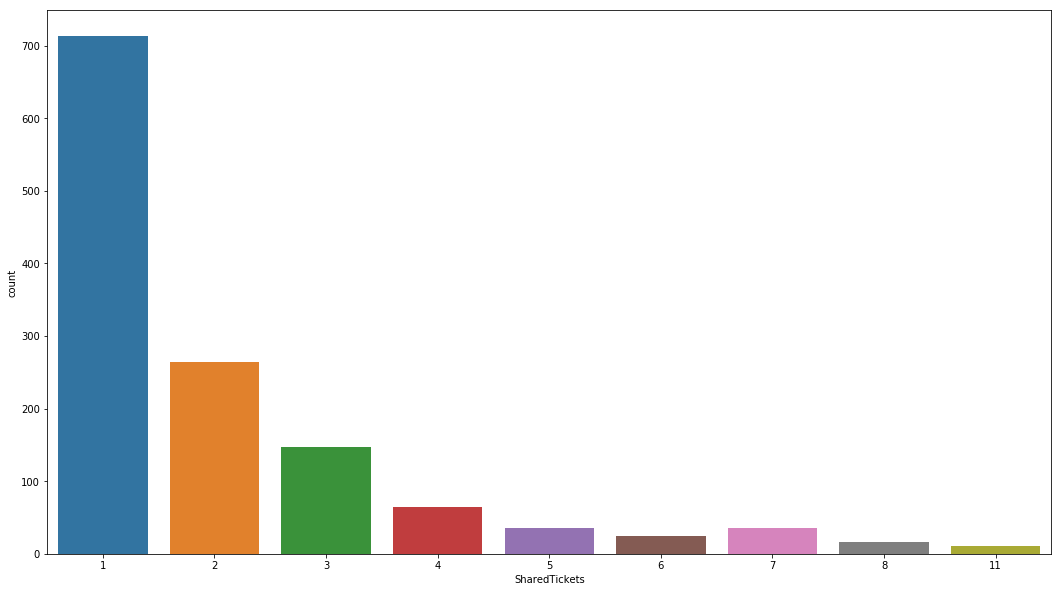

In [75]:
combine['SharedTickets'] = combine.groupby('Ticket')['Name'].transform("count")

plt.figure(figsize=(18, 10))
sns.countplot(combine.SharedTickets)
plt.show()

Are passengers who share tickets more or less likely to perish? To find out, we can use the `sns.distplot` function to find out.

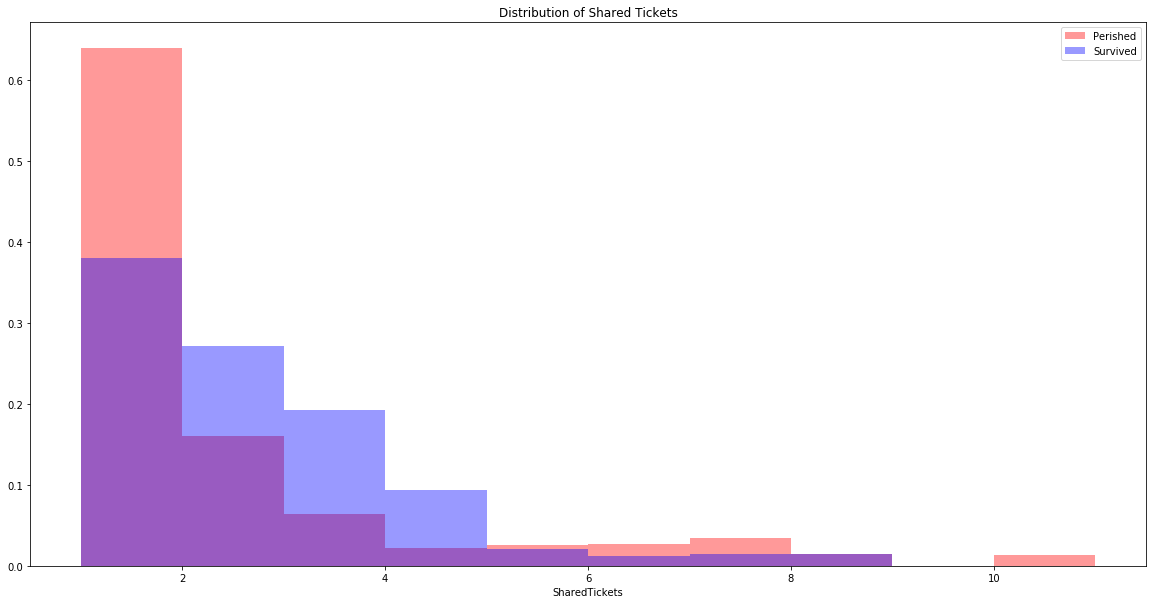

In [76]:
plt.figure(figsize=(20, 10))

sns.distplot(combine[(combine.Survived == 0)].SharedTickets.dropna(),
             bins = range(1, 12, 1), kde = False, norm_hist = True, color = 'red', label='Perished')

sns.distplot(combine[(combine.Survived == 1)].SharedTickets.dropna(),
             bins = range(1, 12, 1), kde = False, norm_hist = True, color = 'blue', label='Survived')

plt.legend(loc='upper right')
plt.title('Distribution of Shared Tickets')
plt.show()

It appears that passengers who shared tickets with 1, 2 or 3 other friends or relative had a higher chance of survival. To capture this, we can create a new feature called "GoodSharedTicket". In addition, we can also create a new column called, "Alone".

In [77]:
combine['GoodSharedTickets'] = ((combine.SharedTickets >= 2) & (combine.SharedTickets <= 4))
combine['Alone'] = combine.SharedTickets == 1

In [78]:
combine.head()

Age Cabin Embarked     Fare  \
PassengerId                                 
1            22.0     N        S   7.2500   
2            38.0   C85        C  71.2833   
3            26.0     N        S   7.9250   
4            35.0  C123        S  53.1000   
5            35.0     N        S   8.0500   

                                                          Name  Parch  Pclass  \
PassengerId                                                                     
1                                      Braund, Mr. Owen Harris      0       3   
2            Cumings, Mrs. John Bradley (Florence Briggs Th...      0       1   
3                                       Heikkinen, Miss. Laina      0       3   
4                 Futrelle, Mrs. Jacques Heath (Lily May Peel)      0       1   
5                                     Allen, Mr. William Henry      0       3   

                Sex  SibSp  Survived            Ticket   LastName  \
PassengerId                                                         
1              male      1       0.0         A/5 21171     Braund   
2            female      1       1.0          PC 17599    Cumings   
3            female      0       1.0  STON/O2. 3101282  Heikkinen   
4            female      1       1.0            113803   Futrelle   
5              male      0       0.0            373450      Allen   

                                         FirstName Designation  NewAge  \
PassengerId                                                              
1                                      Owen Harris          Mr    22.0   
2            John Bradley (Florence Briggs Thayer)         Mrs    38.0   
3                                            Laina        Miss    26.0   
4                    Jacques Heath (Lily May Peel)         Mrs    35.0   
5                                    William Henry          Mr    35.0   

             SharedTickets  GoodSharedTickets  Alone  
PassengerId                                           
1                        1              False   True  
2                        2               True  False  
3                        1              False   True  
4                        2               True  False  
5                        1              False   True

Recall that we had tickets costing more than \$500. Let's take a closer look at those tickets.

In [79]:
combine[combine.Fare >= 500]

Age        Cabin Embarked      Fare  \
PassengerId                                         
259          35.0            N        C  512.3292   
680          36.0  B51 B53 B55        C  512.3292   
738          35.0         B101        C  512.3292   
1235         58.0  B51 B53 B55        C  512.3292   

                                                          Name  Parch  Pclass  \
PassengerId                                                                     
259                                           Ward, Miss. Anna      0       1   
680                         Cardeza, Mr. Thomas Drake Martinez      1       1   
738                                     Lesurer, Mr. Gustave J      0       1   
1235         Cardeza, Mrs. James Warburton Martinez (Charlo...      1       1   

                Sex  SibSp  Survived    Ticket LastName  \
PassengerId                                               
259          female      0       1.0  PC 17755     Ward   
680            male      0       1.0  PC 17755  Cardeza   
738            male      0       1.0  PC 17755  Lesurer   
1235         female      0       NaN  PC 17755  Cardeza   

                                                     FirstName Designation  \
PassengerId                                                                  
259                                                       Anna        Miss   
680                                      Thomas Drake Martinez          Mr   
738                                                  Gustave J          Mr   
1235         James Warburton Martinez (Charlotte Wardle Drake)         Mrs   

             NewAge  SharedTickets  GoodSharedTickets  Alone  
PassengerId                                                   
259            35.0              4               True  False  
680            36.0              4               True  False  
738            35.0              4               True  False  
1235           58.0              4               True  False

There is something similar across all ticket-holders; they all share the same ticket! One theory might be that the ticket fare, \$512.3292, might reflect the joint total instead of the fare each person paid. If we believe this to be true, we can simply create a new fare column by using the fare to divide by the number of people that shared the same ticket.

In [80]:
combine['NormalisedFare'] = combine.Fare / combine.SharedTickets

In [81]:
print('Max Fare is %f' % max(combine.Fare))
print('Max Normalised Fare is %f' % max(combine.NormalisedFare))

Max Fare is 512.329200
Max Normalised Fare is 128.082300


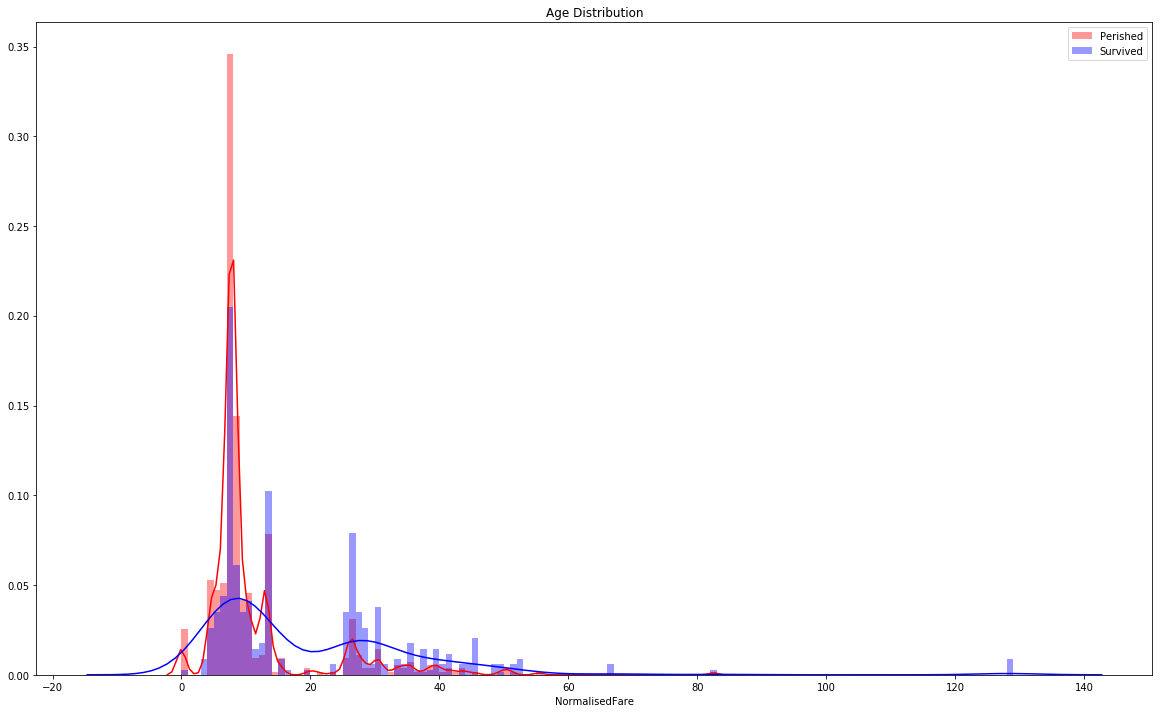

In [82]:
### Revised Hypothesis 2
plt.figure(figsize=(20, 12))
sns.distplot(combine[combine.Survived == 0].NormalisedFare, bins=range(0, 131, 1), color = 'red', label='Perished')
sns.distplot(combine[combine.Survived == 1].NormalisedFare, bins=range(0, 131, 1), color = 'blue', label='Survived')
plt.legend(loc='upper right')
plt.title("Age Distribution")
plt.show()

All in all, the observation that passengers who paid higher fares has a higher rate of survival still stands.

---

#### Investing the Cabin Variable

Finally, we investigate the cabin variable, and check whether we are able to generate any new features from it.

In [83]:
np.unique(combine.Cabin)

array(['A10', 'A11', 'A14', 'A16', 'A18', 'A19', 'A20', 'A21', 'A23',
       'A24', 'A26', 'A29', 'A31', 'A32', 'A34', 'A36', 'A5', 'A6', 'A7',
       'A9', 'B10', 'B101', 'B102', 'B11', 'B18', 'B19', 'B20', 'B22',
       'B24', 'B26', 'B28', 'B3', 'B30', 'B35', 'B36', 'B37', 'B38',
       'B39', 'B4', 'B41', 'B42', 'B45', 'B49', 'B5', 'B50',
       'B51 B53 B55', 'B52 B54 B56', 'B57 B59 B63 B66', 'B58 B60', 'B61',
       'B69', 'B71', 'B73', 'B77', 'B78', 'B79', 'B80', 'B82 B84', 'B86',
       'B94', 'B96 B98', 'C101', 'C103', 'C104', 'C105', 'C106', 'C110',
       'C111', 'C116', 'C118', 'C123', 'C124', 'C125', 'C126', 'C128',
       'C130', 'C132', 'C148', 'C2', 'C22 C26', 'C23 C25 C27', 'C28',
       'C30', 'C31', 'C32', 'C39', 'C45', 'C46', 'C47', 'C49', 'C50',
       'C51', 'C52', 'C53', 'C54', 'C55 C57', 'C6', 'C62 C64', 'C65',
       'C68', 'C7', 'C70', 'C78', 'C80', 'C82', 'C83', 'C85', 'C86',
       'C87', 'C89', 'C90', 'C91', 'C92', 'C93', 'C95', 'C97', 'C99', 'D',
       'D

We note that there are many different types of cabins, and some passengers "share" cabins with other passengers. To capture these effects, we can create a new column, "CabinType" (for example, the cabin type of cabin "A35" is "A"), using the first character of the Cabin feature, and another, "NoCabin" to capture the number of cabins that the passengers were staying in.

/Users/ngbolin/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


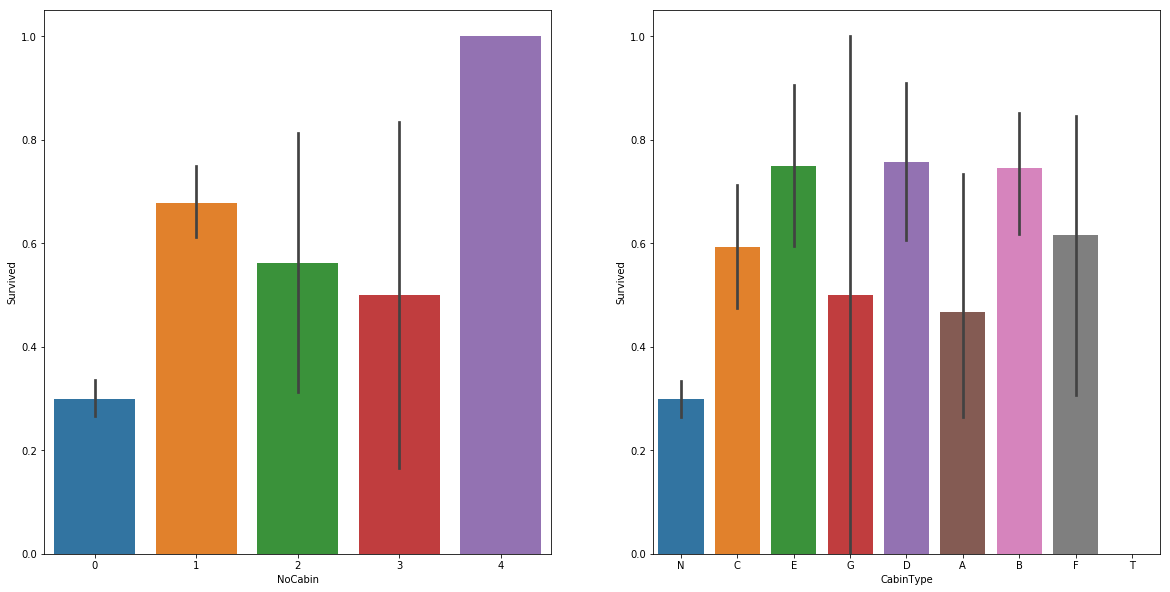

In [84]:
combine['CabinType'] = combine.Cabin.apply(lambda x: x[0])

def number_of_cabins(cabin):
    if cabin == 'N': return 0
    else: return len(cabin.split(' '))
    
combine['NoCabin'] = combine.Cabin.apply(lambda x: number_of_cabins(x))

fig = plt.figure(figsize=(20, 10))
ax1 = fig.add_subplot(121); ax2 = fig.add_subplot(122)

g1 = sns.factorplot('NoCabin', 'Survived', 
                    kind = 'bar', data = combine, ax = ax1)
plt.close(g1.fig)
g2 = sns.factorplot('CabinType', 'Survived', 
                    kind = 'bar', data = combine, ax = ax2)
plt.close(g2.fig)
plt.show()

As it turns out, passengers staying in cabins had a higher possibility of surviving, but the effect does not increase with the number of cabins. In fact, the higher number of cabins, the lower the probability of the passenger surviving. We can then convert this column to categorical instead of numerical to capture the asymmetric effects.

From the Cabin types, we note that passengers staying in the "E", "D", and "B" cabins had a higher survival rate. 

In [85]:
combine['NoCabin'] = pd.Categorical(combine.NoCabin)
print(combine.NoCabin.dtypes)

category


### Feature Selection

After all this, we can begin to select features which we believe are informative of the response variable. We typically do so using a heatmap/correlation plot.

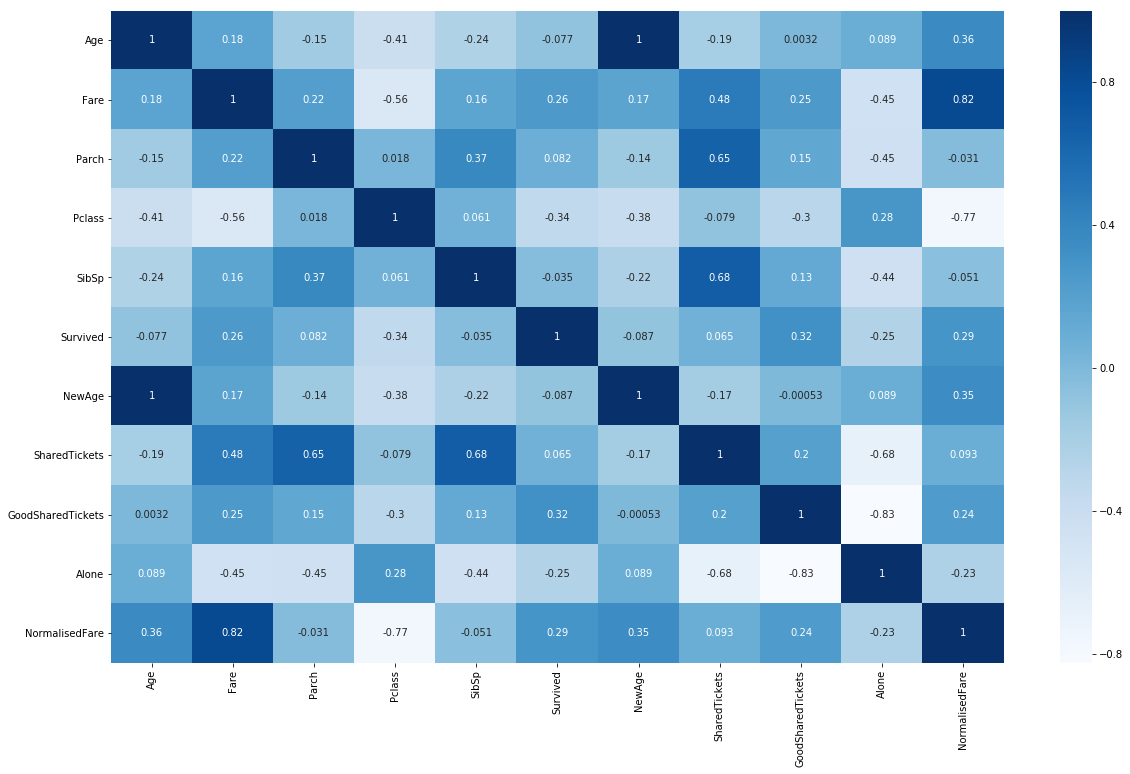

In [86]:
plt.figure(figsize=(20, 12))
sns.heatmap(combine.corr(), cmap='Blues', annot=True)
plt.show()

From the correlation plot, we note that the following features seem to be fairly highly correlated with the "Survived" feature:

1. NormalisedFare
2. GoodSharedTickets
3. NewAge
4. PassengerClass

In addition, we will include some other categorical features not included in the correlation plots:

1. Gender
2. CabinType
3. NoCabin
4. Designation

In [87]:
features = ['NormalisedFare', 'GoodSharedTickets', 'NewAge', 'Pclass', 'Alone',
            'Sex', 'CabinType', 'NoCabin', 'Designation']

X = combine[features]
y = combine['Survived']

In the next section, we introduce several libaries that are useful for the purpose of our analysis. In addition, we start off with a basic example to get a better understanding of the libraries.

This section was lifted from [Real Python](https://realpython.com/linear-regression-in-python/).

We begin with a gentle introduction to Simple Linear Regression with Python. 

Note that we have to provide a 2-dimensional array for the independent variables, since 1 dimension is used as a count of the number of observations, while the other stores the potential independent variables (could be more than 1). We can do this easily with the `reshape` method.

In [88]:
# Importing the linear_model library from sklearn
from sklearn import linear_model

# Define x and y
x0 = np.array([5, 15, 25, 35, 45, 55]).reshape([-1,1]) # Reshape here reshapes the array into 2 dimensions.
y0 = np.array([5, 20, 14, 32, 22, 38])

print(x0)
print(y0)

[[ 5]
 [15]
 [25]
 [35]
 [45]
 [55]]
[ 5 20 14 32 22 38]


In [89]:
# First, we tell Python that the model of choice is the linear regression model
model = linear_model.LinearRegression(fit_intercept=True)
model.fit(x0,y0)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [90]:
# After fitting, we can obtain the R-sq, intercept and coefficient of the parameter of interest
r_sq = model.score(x0,y0)
print(r_sq)
print(model.intercept_)
print(model.coef_[0])

0.715875613747954
5.633333333333333
0.5399999999999999


In [91]:
# Finally, to use the fitted model for prediction, we can simply call the prediction function of the model
model.predict(x0)

array([ 8.33333333, 13.73333333, 19.13333333, 24.53333333, 29.93333333,
       35.33333333])

Next, we look at an example that uses multiple variables - Multiple Linear Regression

In [92]:
x1 = [[0, 1], [5, 1], [15, 2], [25, 5], [35, 11], [45, 15], [55, 34], [60, 35]]
y1 = [4, 5, 20, 14, 32, 22, 38, 43]

# We have 8 observations and 2 independent variables
len(x1)

8

In [93]:
# To run a multiple linear regression, we can do the same
model = linear_model.LinearRegression(fit_intercept=True)
model.fit(x1,y1)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [94]:
r_sq = model.score(x1,y1)
print(r_sq)
print(model.intercept_)
print(model.coef_) # Note that model.coef_ returns a list since there might be more than 1X

0.8615939258756776
5.522579275198183
[0.44706965 0.25502548]


In [95]:
model.predict(x1)

array([ 5.77760476,  8.012953  , 12.73867497, 17.9744479 , 23.97529728,
       29.4660957 , 38.78227633, 41.27265006])

Now that we have a working understanding of how to run a linear regression, let's apply this knowledge to the Titanic dataset. Before we can run the analysis, recall that we have categorical data - we have to One-Hot 

In [96]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder() # We drop the first category to avoid multicollinearity issues

catfeatures = ['GoodSharedTickets', 'NoCabin', 'Pclass', 'Alone', 'Sex', 'CabinType', 'Designation']
for feature in catfeatures:
    Z = pd.get_dummies(X[feature])
    X = pd.merge(X,Z,left_index=True,right_index=True)

In [97]:
for feature in catfeatures:
    del X[feature]

In [98]:
X.head()

NormalisedFare  NewAge  False_x  True_x  0_y  1_y  2_x  3_x  4  \
PassengerId                                                                   
1                   7.25000    22.0        1       0    1    0    0    0  0   
2                  35.64165    38.0        0       1    0    1    0    0  0   
3                   7.92500    26.0        1       0    1    0    0    0  0   
4                  26.55000    35.0        0       1    0    1    0    0  0   
5                   8.05000    35.0        1       0    1    0    0    0  0   

             1_x  ...  Master  Miss  Mlle  Mme  Mr  Mrs  Ms  Rev  Sir  \
PassengerId       ...                                                   
1              0  ...       0     0     0    0   1    0   0    0    0   
2              1  ...       0     0     0    0   0    1   0    0    0   
3              0  ...       0     1     0    0   0    0   0    0    0   
4              1  ...       0     0     0    0   0    1   0    0    0   
5              0  ...       0     0     0    0   1    0   0    0    0   

             the Countess  
PassengerId                
1                       0  
2                       0  
3                       0  
4                       0  
5                       0  

[5 rows x 43 columns]

Next, to avoid the issue of multicollinearity, we remove several columns, such as "False_x" and "False_y"

In [99]:
X.columns

Index(['NormalisedFare',         'NewAge',        'False_x',         'True_x',
                  '0_y',            '1_y',            '2_x',            '3_x',
                      4,            '1_x',            '2_y',            '3_y',
                  False,         'True_y',         'female',           'male',
                    'A',              'B',              'C',              'D',
                    'E',              'F',              'G',              'N',
                    'T',           'Capt',            'Col',            'Don',
                 'Dona',             'Dr',       'Jonkheer',           'Lady',
                'Major',         'Master',           'Miss',           'Mlle',
                  'Mme',             'Mr',            'Mrs',             'Ms',
                  'Rev',            'Sir',   'the Countess'],
      dtype='object')

In [100]:
multicollinear_cols = ["False_x", "0_y", "1_x", False, "female", "A", "Capt"]
for col in multicollinear_cols:
    del X[col]

In [101]:
for col in X.columns:
    X[col] = X[col].astype(float)

In [103]:
model = linear_model.LinearRegression()
# Only the training data is used to fit a line of best fit
model.fit(X[:len(train)].values,y[:len(train)])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [105]:
r_sq = model.score(X[:len(train)].values,y[:len(train)])
print(r_sq)
print(model.intercept_)
print(model.coef_)

0.46078577060095083
0.39607485392098774
[ 3.95920225e-03 -4.01081539e-03  3.14903383e-01 -6.08759260e-02
 -1.32668817e-01  1.32192835e-02  2.63741750e-01 -4.35892134e-02
 -1.69902674e-01  3.19345181e-01 -5.62145934e-01  5.22490210e-02
  2.41799029e-02  1.41582282e-01  2.13284221e-01  9.28195425e-02
 -2.04388277e-01 -8.34162899e-02 -3.27196488e-01  5.28665050e-01
 -1.91774491e-02 -8.19467995e-16  2.97744616e-01  8.25531739e-02
  3.81190621e-01  4.50975665e-01  7.61813090e-01  2.17745891e-01
  2.39130148e-01  2.56721880e-01  2.74733326e-01  3.06199306e-01
  4.72418670e-01  9.89379881e-02  9.95876469e-01  3.15848578e-01]
